In [171]:
import numpy as np
from ipykernel.compiler import murmur2_x86
from pyod.models.lof import LOF
from pyod.utils.data import generate_data_clusters
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_blobs
import scipy
from pyod.models.combination import maximization, average
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyod.utils import standardizer


In [216]:

standard_label = "standard"
var_x_label = "var_x"
var_y_label = "var_y"
var_x_y_label = "var_x_y"


def add_bias_column_1d(x):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([np.ones((x.shape[0], 1)), x])
    return X

def add_bias_column_2d(X):
    X = np.asarray(X)
    return np.hstack([np.ones((X.shape[0], 1)), X])

def leverage_scores(X):
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    return np.diag(H)

def generate_data_1d(n = 100,m = 25,mu = 0, sigma = 1.0,a = 4,b = -0.5,rng = None):

    # Standard distribution
    x_std = rng.normal(0,1.0,n)

    # Variance oscillation
    x_high_var_x = rng.normal(0,5.0,m)
    x_high_var_y = rng.normal(0,2.0,m)
    x_high_var_x_y = rng.normal(0,5.0,m)

    x = np.concatenate([x_std,x_high_var_x,x_high_var_y,x_high_var_x_y])

    # Noise

    epsilon_std = rng.normal(mu,sigma,n)
    epsilon_high_var_x = rng.normal(mu,sigma,m)
    epsilon_high_var_y = rng.normal(mu,6.0 * sigma,m)
    epsilon_high_var_x_y = rng.normal(mu,6.0 * sigma,m)

    epsilon = np.concatenate([epsilon_std,epsilon_high_var_x,epsilon_high_var_y,epsilon_high_var_x_y])

    labels = np.array([standard_label] * n + [var_x_label] * m + [var_y_label] * m + [var_x_y_label] * m)

    y = a * x + b + epsilon
    return x,y,labels

def generate_data_2d(n=100, m=25, mu=0, sigma=1.0, a=4.0, b=2.0, c=-0.5, rng=None):

    x1_std = rng.normal(0, 1.0, n)
    x2_std = rng.normal(0, 1.0, n)


    x1_var_x = rng.normal(0, 5.0, m)
    x2_var_x = rng.normal(0, 5.0, m)

    x1_var_y = rng.normal(0, 1.0, m)
    x2_var_y = rng.normal(0, 1.0, m)

    # High variance on both x & y
    x1_var_x_y = rng.normal(0, 5.0, m)
    x2_var_x_y = rng.normal(0, 5.0, m)


    x1 = np.concatenate([x1_std, x1_var_x, x1_var_y, x1_var_x_y])
    x2 = np.concatenate([x2_std, x2_var_x, x2_var_y, x2_var_x_y])
    X = np.column_stack([x1, x2])

    eps_std   = rng.normal(mu, sigma, n)
    eps_varx  = rng.normal(mu, sigma, m)
    eps_vary  = rng.normal(mu, 6.0 * sigma, m)
    eps_varxy = rng.normal(mu, 6.0 * sigma, m)

    eps = np.concatenate([eps_std, eps_varx, eps_vary, eps_varxy])

    labels = np.array(
        [standard_label] * n
        + [var_x_label] * m
        + [var_y_label] * m
        + [var_x_y_label] * m
    )

    # y = a*x1 + b*x2 + c + eps
    y = a * x1 + b * x2 + c + eps
    return X, y, labels


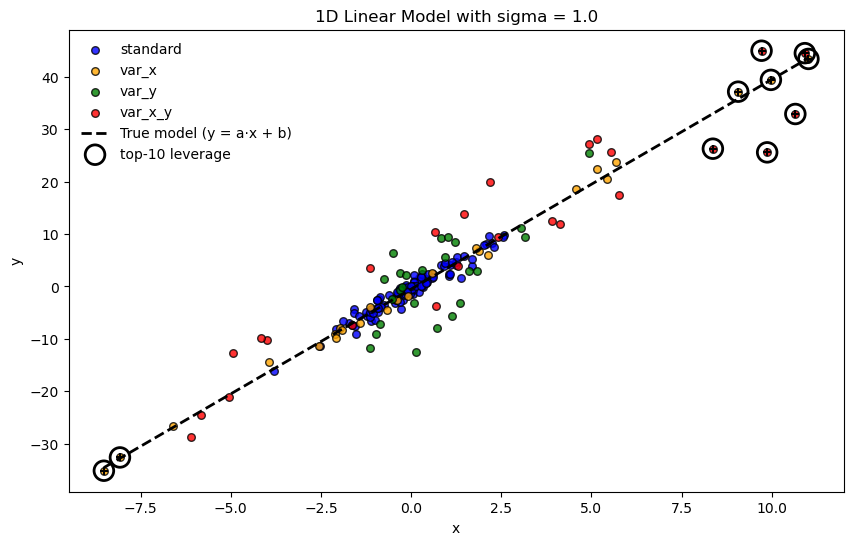

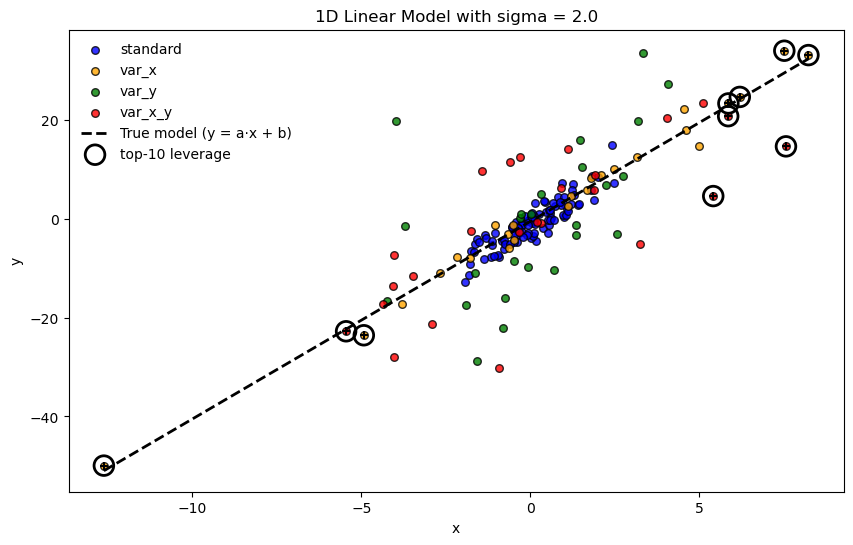

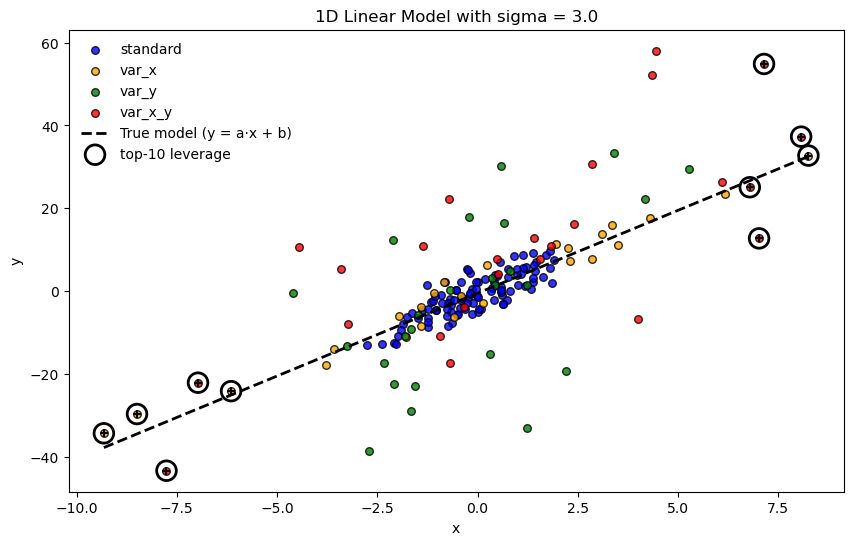

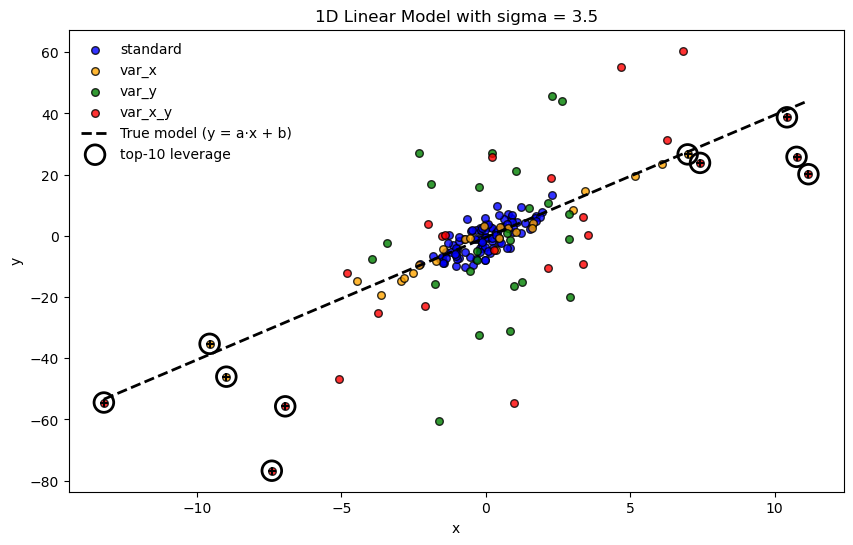

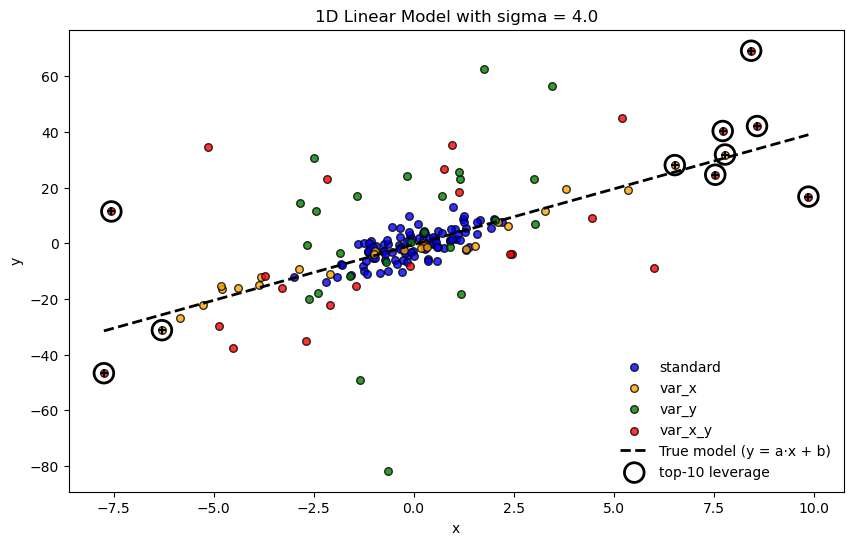

In [215]:
# 1D

rng = np.random.default_rng(9000)
a = 4
b = -0.5
mu = 0.0
sigma = 3.0
k = 10 # top k leverage scores

sigmas = [1.0,2.0,3.0,3.5,4.0]

for sigma in sigmas:
    x, y, labels = generate_data_1d(mu=mu,sigma=sigma,a=a,b=b,rng=rng)
    H = leverage_scores(add_bias_column_1d(x))

    plt.figure(figsize=(10, 6))
    colors = {
        standard_label: "blue",
        var_x_label: "orange",
        var_y_label: "green",
        var_x_y_label: "red",
    }


    for lbl, color in colors.items():
        mask = labels == lbl
        plt.scatter(x[mask], y[mask], s=30, c=color, label=lbl, alpha=0.8, edgecolors="k")

    x_line = np.linspace(np.min(x), np.max(x), 200)
    y_line = a * x_line + b
    plt.plot(x_line, y_line, "k--", linewidth=2.0, label="True model (y = a·x + b)")

    plt.title(f"1D Linear Model with sigma = {sigma}")
    plt.xlabel("x")
    plt.ylabel("y")


    top_idx = np.argsort(H)[-k:]
    top_x = x[top_idx]
    top_y = y[top_idx]


    plt.scatter(top_x, top_y,
                s=200, facecolors='none', edgecolors='black',
                linewidths=2.0, label=f'top-{k} leverage')

    plt.scatter(top_x, top_y, s=30, marker='+', color='black')

    plt.legend(frameon=False, loc='best')
    plt.show()



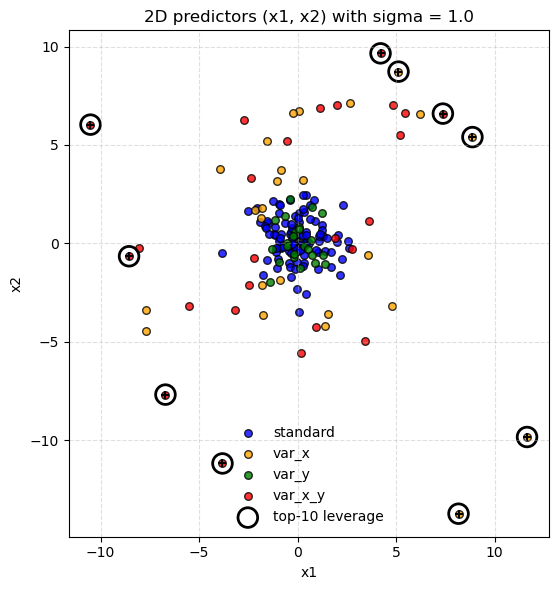

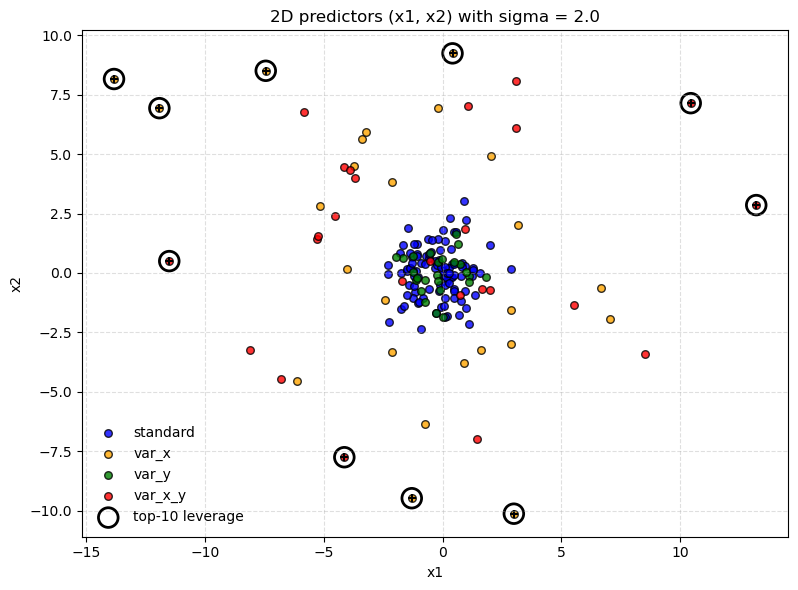

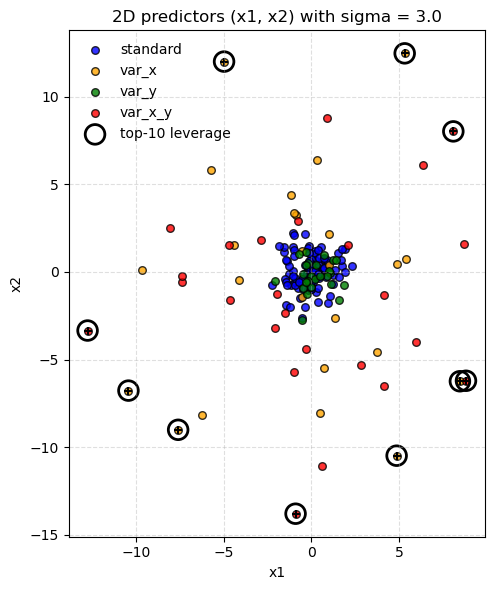

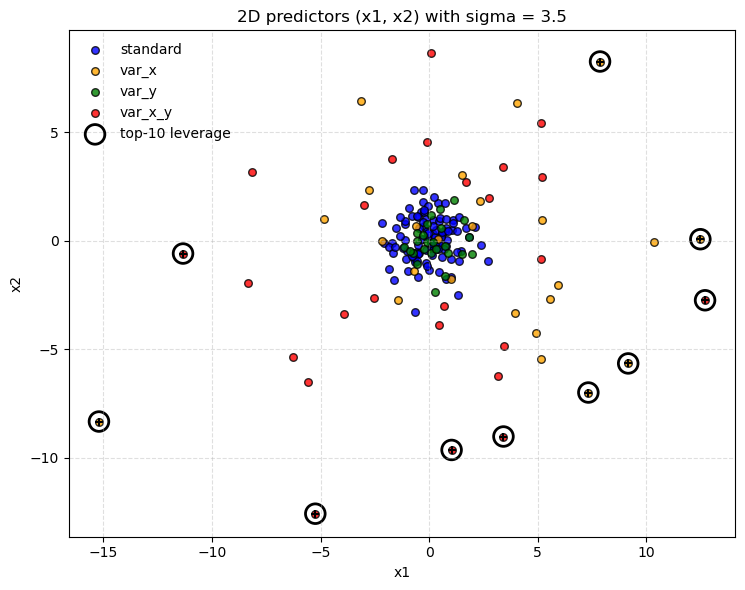

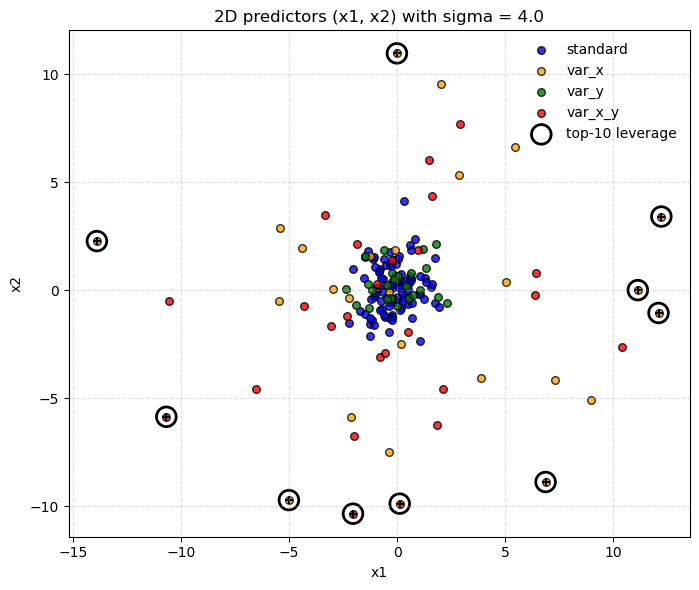

In [217]:
#2D

rng = np.random.default_rng(9000)
a = 4.0
b = 2.0
c = -0.5
mu = 0.0
k = 10      # top-k leverage
sigmas = [1.0, 2.0, 3.0, 3.5, 4.0]

colors = {
    standard_label: "blue",
    var_x_label: "orange",
    var_y_label: "green",
    var_x_y_label: "red",
}

for sigma in sigmas:
    X, y, labels = generate_data_2d(mu=mu, sigma=sigma, a=a, b=b, c=c, rng=rng)

    H = leverage_scores(add_bias_column_2d(X))

    plt.figure(figsize=(10, 6))

    for lbl, color in colors.items():
        mask = labels == lbl
        plt.scatter(X[mask, 0], X[mask, 1], s=30, c=color, label=lbl,
                    alpha=0.8, edgecolors="k")

    top_idx = np.argsort(H)[-k:]
    top_x1x2 = X[top_idx]

    plt.scatter(top_x1x2[:, 0], top_x1x2[:, 1],
                s=200, facecolors='none', edgecolors='black',
                linewidths=2.0, label=f'top-{k} leverage')
    plt.scatter(top_x1x2[:, 0], top_x1x2[:, 1],
                s=30, marker='+', color='black')

    plt.title(f"2D predictors (x1, x2) with sigma = {sigma}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(frameon=False, loc='best')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.tight_layout()
    plt.show()

# EX 2

In [118]:

x_train,x_test,y_train, y_test = generate_data_clusters(n_train=400,
                                                        n_test=200,
                                                        n_clusters=2,
                                                        n_features=2,
                                                        contamination=0.1,
                                                        random_state=9000)

k_neighbours = [1,3,5,7,9,11,13,15,17,19,21,25,30,40,50]

for k in k_neighbours:
    model = KNN(n_neighbors=k,contamination=0.1)
    model.fit(x_train)
    y_pred = model.predict(x_test)
    ba = balanced_accuracy_score(y_test,y_pred)
    print(f" k = {k}, balanced accuracy = {ba}")

 k = 1, balanced accuracy = 0.9943820224719101
 k = 3, balanced accuracy = 0.9915730337078652
 k = 5, balanced accuracy = 0.9915730337078652
 k = 7, balanced accuracy = 0.997191011235955
 k = 9, balanced accuracy = 0.997191011235955
 k = 11, balanced accuracy = 0.9943820224719101
 k = 13, balanced accuracy = 0.997191011235955
 k = 15, balanced accuracy = 0.9943820224719101
 k = 17, balanced accuracy = 0.9887640449438202
 k = 19, balanced accuracy = 0.9943820224719101
 k = 21, balanced accuracy = 0.9915730337078652
 k = 25, balanced accuracy = 0.9943820224719101
 k = 30, balanced accuracy = 0.9943820224719101
 k = 40, balanced accuracy = 0.9915730337078652
 k = 50, balanced accuracy = 0.9943820224719101


/home/gabroveanu-razvan/anaconda3/envs/anomaly/lib/python3.13/site-packages/pyod/models/base.py:554: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


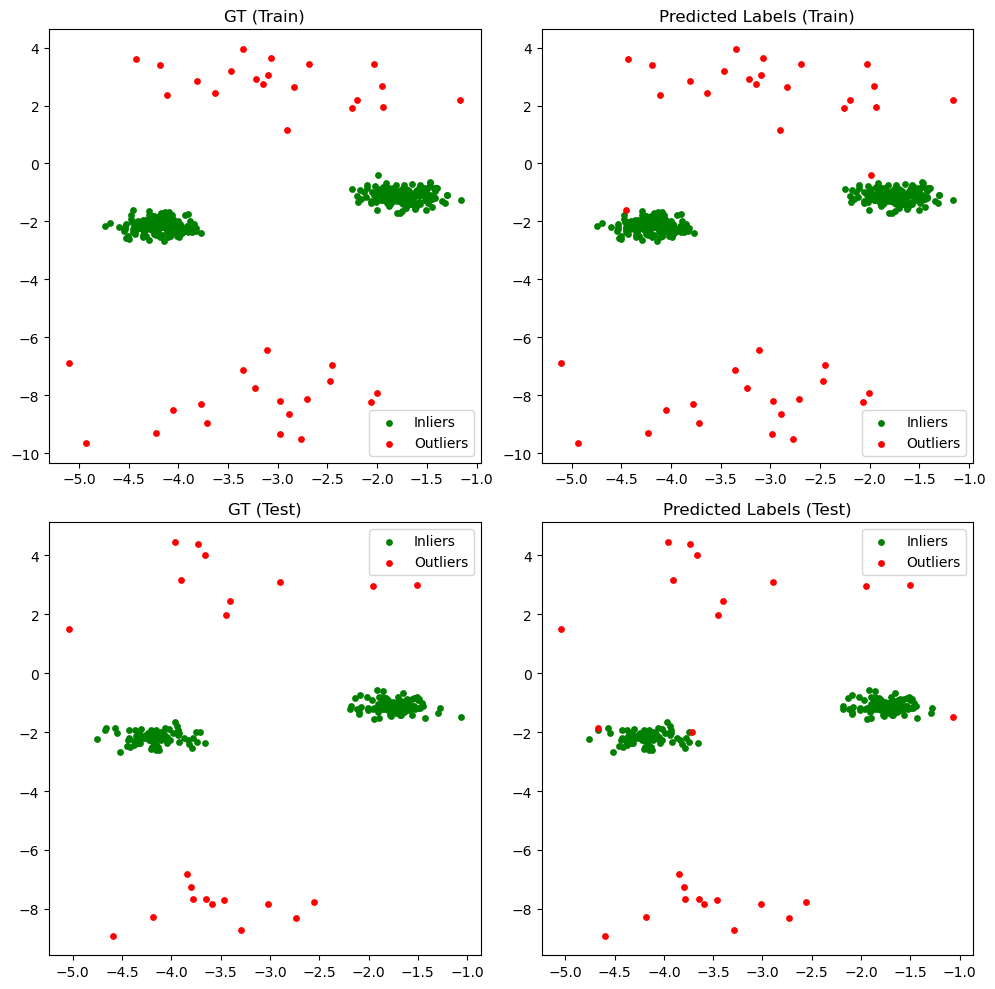

In [129]:

k = 5
model = KNN(n_neighbors=k,contamination=0.1)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
titles = [
    "GT (Train)",
    "Predicted Labels (Train)",
    "GT (Test)",
    "Predicted Labels (Test)",
]
data_sets = [
    (x_train, y_train),
    (x_train, y_train_pred),
    (x_test, y_test),
    (x_test, y_pred),
]

for ax, (X, y), title in zip(axes.ravel(), data_sets, titles):
    inliers = X[y == 0]
    outliers = X[y == 1]
    ax.scatter(inliers[:,0], inliers[:,1], c="green", label="Inliers", s=15)
    ax.scatter(outliers[:,0], outliers[:,1], c="red", label="Outliers", s=15)
    ax.set_title(title)
    ax.legend()

plt.tight_layout()

# EX 3

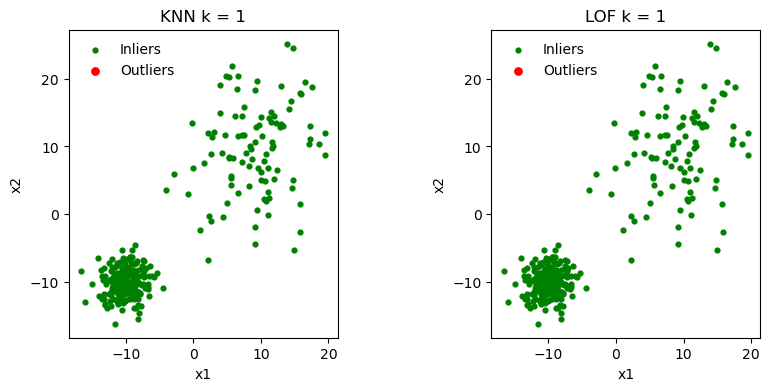

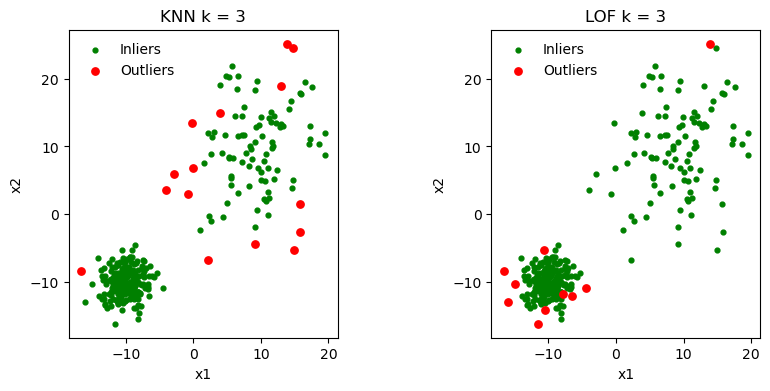

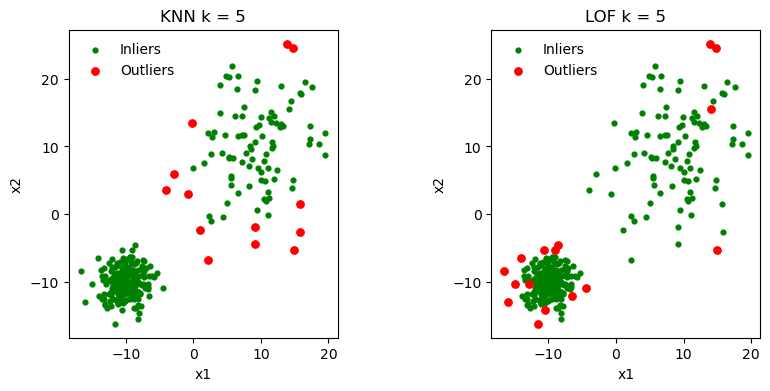

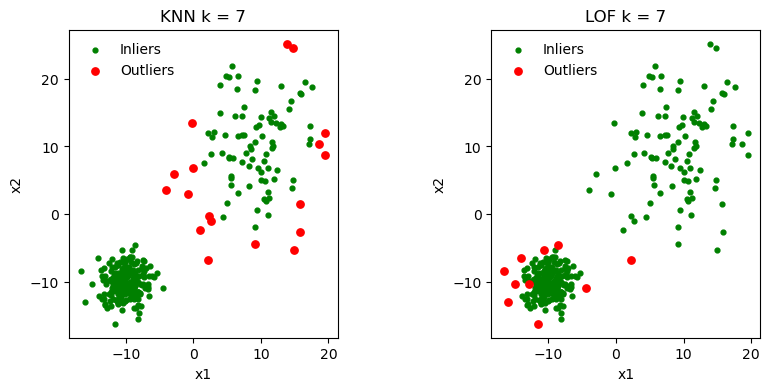

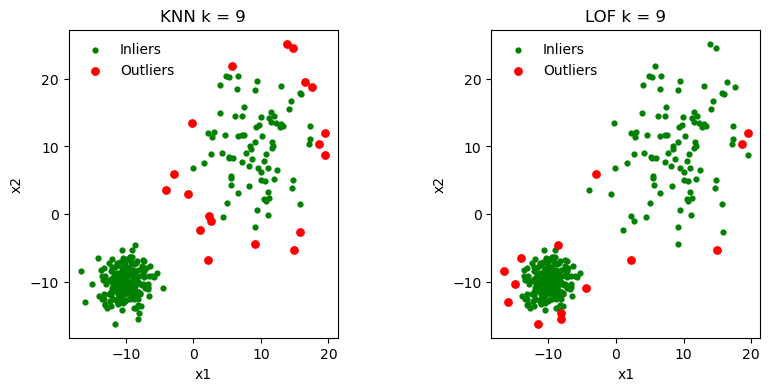

In [165]:
x, _ = make_blobs(
    n_samples=[200, 100],
    centers=[(-10, -10), (10, 10)],
    cluster_std=[2, 6],
    n_features=2,
    random_state=9000,
)

k_list = [1,3,5,7,9]

for k  in k_list:

    knn = KNN(n_neighbors=k,contamination=0.07)
    knn.fit(x)
    y_knn = knn.predict(x)

    lof = LOF(n_neighbors=k,contamination=0.07)
    lof.fit(x)
    y_lof = lof.predict(x)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4*1))

    # KNN plot
    inliers = y_knn == 0
    outliers = y_knn == 1

    knn_ax = axes[0]
    knn_ax.scatter(x[inliers, 0], x[inliers, 1], s=12, c="green", label="Inliers")
    knn_ax.scatter(x[outliers, 0], x[outliers, 1], s=28, c="red", label="Outliers")
    knn_ax.set_title(f"KNN k = {k}")
    knn_ax.set_xlabel("x1")
    knn_ax.set_ylabel("x2")
    knn_ax.legend(frameon=False, loc="best")
    knn_ax.set_aspect("equal", adjustable="box")


    # LOF plot
    inliers = y_lof == 0
    outliers = y_lof == 1

    lof_ax = axes[1]
    lof_ax.scatter(x[inliers, 0], x[inliers, 1], s=12, c="green", label="Inliers")
    lof_ax.scatter(x[outliers, 0], x[outliers, 1], s=28, c="red", label="Outliers")
    lof_ax.set_title(f"LOF k = {k}")
    lof_ax.set_xlabel("x1")
    lof_ax.set_ylabel("x2")
    lof_ax.legend(frameon=False, loc="best")
    lof_ax.set_aspect("equal", adjustable="box")




# EX 4

In [194]:

# Extract data and labels, split it and scale it
data = scipy.io.loadmat("cardio.mat")

x = data["X"]
y = data["y"].ravel().astype(int)

# 20% testing 80% training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000, stratify=y)
print(f"Train outliers: {y_train.sum()} out of {y_train.size}")
print(f"Test outliers: {y_test.sum()} out of {y_test.size}")

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test  = scaler.transform(x_test)

Train outliers: 141 out of 1464
Test outliers: 35 out of 367


In [196]:

k_list = np.arange(30, 121, 5, dtype=np.uint8)
contamination = 0.1

train_scores = []
test_scores  = []

# Train the model, get the scores
for k in k_list:
    model = KNN(n_neighbors=k, contamination=contamination)
    model.fit(X_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    ba_train = balanced_accuracy_score(y_train, y_pred_train)
    ba_test = balanced_accuracy_score(y_test,  y_pred_test)
    print(f"Balanced scores for k = {k}: train: {ba_train} test: {ba_test} ")

    train_scores.append(model.decision_scores_.reshape(-1, 1))
    test_scores.append(model.decision_function(X_test).reshape(-1, 1))

scores_train = np.hstack(train_scores)
scores_test  = np.hstack(test_scores)

scores_train_std, scores_test_std = standardizer(scores_train, scores_test)

avg_train = average(scores_train_std)
avg_test  = average(scores_test_std)

max_train = maximization(scores_train_std)
max_test  = maximization(scores_test_std)



q = 1.0 - contamination
threshold_avg = np.quantile(avg_train, q)
threshold_max = np.quantile(max_train, q)

y_avg_pred_train = (avg_train >= threshold_avg).astype(int)
y_avg_pred_test = (avg_test  >= threshold_avg).astype(int)

y_max_pred_train = (max_train >= threshold_max).astype(int)
y_max_pred_test = (max_test  >= threshold_max).astype(int)

ba_avg_tr = balanced_accuracy_score(y_train, y_avg_pred_train)
ba_avg_te = balanced_accuracy_score(y_test,  y_avg_pred_test)
ba_max_tr = balanced_accuracy_score(y_train, y_max_pred_train)
ba_max_te = balanced_accuracy_score(y_test,  y_avg_pred_test)

print()
print("Results:")
print(f"Average training balanced score: {ba_avg_tr:.3f} and testing balanced score: {ba_avg_te:.3f}")
print(f"Maximization training balanced score: {ba_max_tr:.3f} and testing balanced score: {ba_max_te:.3f}")

Balanced scores for k = 30: train: 0.6907576269278397 test: 0.6969449225473322 
Balanced scores for k = 35: train: 0.6970939676106849 test: 0.6969449225473322 
Balanced scores for k = 40: train: 0.7155803219633007 test: 0.7142426850258176 
Balanced scores for k = 45: train: 0.7230504494942185 test: 0.7172547332185887 
Balanced scores for k = 50: train: 0.724184236342291 test: 0.7315404475043029 
Balanced scores for k = 55: train: 0.7273524066837136 test: 0.7315404475043029 
Balanced scores for k = 60: train: 0.7316543638732089 test: 0.7315404475043029 
Balanced scores for k = 65: train: 0.7316543638732089 test: 0.7315404475043029 
Balanced scores for k = 70: train: 0.7316543638732089 test: 0.7315404475043029 
Balanced scores for k = 75: train: 0.7355783921133465 test: 0.7315404475043029 
Balanced scores for k = 80: train: 0.7395024203534841 test: 0.7315404475043029 
Balanced scores for k = 85: train: 0.7398803493028416 test: 0.7172547332185887 
Balanced scores for k = 90: train: 0.7508